# Yenisey River 2016 (pCO2) 
> https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2V97ZR7H <br><br>
- Surface water was pumped into the equilibrators and headspace was sampled by Picarro CRDS (G2201i) analyzer. <br><br>
- Atmosphere was sampled by a Picarro CRDS (G2201i) analyzer placed 3m above the water. <br><br>
- Wind Speed, Wind Direction, Air Temperature, Humidity, and Barometric Pressure were measured with a weather station (Airmar 220WX) mounted at 10m hight. <br><br>
- Long Wave and Short Wave radiation was measured using Hukseflux SR11 pyranometer (short wave) and Hukseflux IR02 pyrgeometer (long wave) mounted 3m above water. <br><br>
- A High frequency temperature sensor (RBR duet) along with an ADCP (Teledyne Rio Grande workhorse, 600 kHz) to determine turbulent mixing in the surface waters. <br><br>
> - co2_w , ico2_w , ch4_w , ich4_w
> - co2_a , ico2_a , ch4_a , ich4_a
> - u , dir , t_air , rh , p_bar
> - lwr , swr


Contains pin averaged (1 min) concentration and isotopic composition of CO2 and CH4 in air

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Change Directory
import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("default") # notebook, paper, poster
%matplotlib inline
from matplotlib import ticker
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
hours  =  mdates.HourLocator()
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')

from scipy.stats import zscore
import scipy.stats as stats

# Import Water Data (Amon_2016_Yenisei)
waterfile = 'Amon_2016_Yenisei_Water.txt'
water = pd.read_csv(waterfile, sep ='\t',  parse_dates=[0])
water.columns = water.columns.str.strip()
water.index = water['date_time']
water['year'] = pd.DatetimeIndex(water['date_time']).year
water['month'] = pd.DatetimeIndex(water['date_time']).month
water['day'] = pd.DatetimeIndex(water['date_time']).day
water['hour'] = pd.DatetimeIndex(water['date_time']).hour
water = water.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
water = water.dropna(how='any')

# Import Air Data (Amon_2016_Yenisei)
airfile = 'Amon_2016_Yenisei_Air.txt'
air = pd.read_csv(airfile, sep ='\t',  parse_dates=[0])
air.columns = air.columns.str.strip()
air.index = air['date_time']
air['year'] = pd.DatetimeIndex(air['date_time']).year
air['month'] = pd.DatetimeIndex(air['date_time']).month
air['day'] = pd.DatetimeIndex(air['date_time']).day
air['hour'] = pd.DatetimeIndex(air['date_time']).hour
air = air.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
air = air.dropna(how='any')

# Copies
water_raw = water.copy()
air_raw = air.copy()


# Find Max/Min For a column and Show one other Columns
def find_min_max_1(dataframe, column_name):
    min_val, min_date = dataframe[column_name].min(), dataframe[column_name].idxmin()
    max_val, max_date = dataframe[column_name].max(), dataframe[column_name].idxmax()
    print(f"Min {column_name} @ {min_val} on {min_date}")
    print(f"Max {column_name} @ {max_val} on {max_date}")
    
# Find Max/Min For a column and Show two other Columns
def find_min_max_2(dataframe, primary_col, additional_col):
    """
    Find and print the minimum and maximum values of a specified column in a DataFrame, 
    along with the corresponding values of another column at those points.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.
    primary_col (str): The name of the primary column to find min and max values.
    additional_col (str): The name of the additional column for retrieving related values.

    Returns:
    None: This function prints the results and does not return a value.
    """
    # Find min and max of the primary column
    min_val, min_date = dataframe[primary_col].min(), dataframe[primary_col].idxmin()
    max_val, max_date  = dataframe[primary_col].max(), dataframe[primary_col].idxmax()
    # Retrieve values from the additional column at min and max dates
    additional_val_at_min = dataframe.loc[min_date, additional_col]
    additional_val_at_max = dataframe.loc[max_date, additional_col]
    print(f"Min {primary_col} @ {min_val:.1f} on {min_date} @ {additional_col}: {additional_val_at_min}")
    print(f"Max {primary_col} @ {max_val:.1f} on {max_date} @ {additional_col}: {additional_val_at_max}")

# Histograms
def plot_columns_single_row(df, columns, bins=51, alpha=0.7, sharey=True):
    """
    Plots histograms for specified columns in a DataFrame, all in a single row.

    :df: DataFrame containing the data.
    :columns: List of column names (str) to plot.
    :bins: Number of bins for the histogram.
    :alpha: Alpha blending value for the histogram.
    
    Returns:
    None: This function creates a plot but does not return any value.
    """
    num_cols = len(columns)
    fig, ax = plt.subplots(1, num_cols, figsize=(9, 3), sharey=sharey)

    ax[0].set_ylabel('Frequency', labelpad=20, fontsize=12)
    ax[0].yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
    
    for i, col in enumerate(columns):
        data = df[col]
        mean = data.mean()
        std = data.std()
        
        # Histogram plot
        counts, bins_array, patches = ax[i].hist(data, bins=bins, edgecolor='black', color='green', alpha=alpha)

        # Find the bin with the maximum frequency
        max_count = counts.max()
        max_bin_index = counts.argmax()
        max_bin_value = bins_array[max_bin_index]

        # Add vertical and horizontal lines
        ax[i].axhline(y=max_count, color='r', linestyle='dashed', lw=1)
        ax[i].axvline(x=max_bin_value, color='r', linestyle='dashed', lw=1)

        ax[i].set_title(f'{col}', fontsize=16)
        ax[i].text(0.925, 0.95, f'μ: {mean:.1f}', fontsize=12, ha='right', va='top', 
                   transform=ax[i].transAxes)
        ax[i].text(0.925, 0.88, f'σ: {std:.1f}', fontsize=12, ha='right', va='top', 
                   transform=ax[i].transAxes)
        ax[i].xaxis.set_major_locator(MaxNLocator(6))
        ax[i].xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

    plt.tight_layout(pad=0.5)
    plt.show()
    
    return fig, ax

# Quick
min_lat, min_date = water['lat_w'].min(), water['lat_w'].idxmin()
max_lat, max_date = water['lat_w'].max(), water['lat_w'].idxmax()
print(f"Min Latitude @ {min_lat}°N on {min_date}")
print(f"Max Latitude @ {max_lat}°N on {max_date}")

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------
Min Latitude @ 56.23942553°N on 2016-07-23 13:08:00
Max Latitude @ 68.26089092°N on 2016-08-03 16:54:00


In [2]:
# Folder to Save Images (# Laptop @ J: ##### Desktop @ J:)
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')

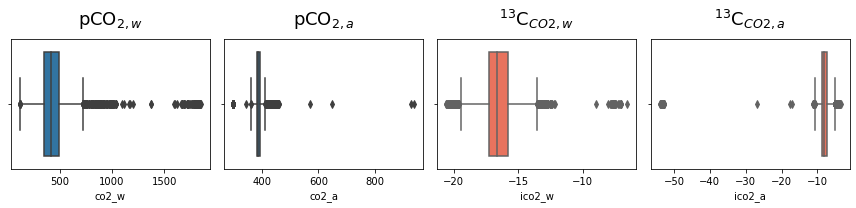

In [3]:
# Set figure and axes
fig, ax = plt.subplots(1,4,figsize =(12,3))

# Box plot
sns.boxplot(x=water['co2_w'], ax=ax[0])
sns.boxplot(x=air['co2_a'], ax=ax[1])
sns.boxplot(x=water['ico2_w'], ax=ax[2], color='tomato')
sns.boxplot(x=air['ico2_a'], ax=ax[3], color='tomato')
# Titles
ax[0].set_title('pCO$_{2,w}$', fontsize=18, pad=15)
ax[1].set_title('pCO$_{2,a}$', fontsize=18, pad=15)
ax[2].set_title('$^{13}$C$_{CO2,w}$', fontsize=18, pad=15)
ax[3].set_title('$^{13}$C$_{CO2,a}$', fontsize=18, pad=15)
fig.tight_layout()

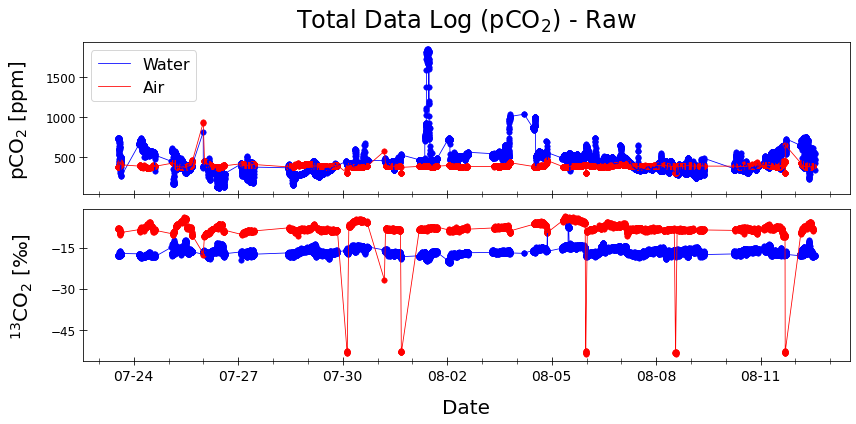

In [4]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
ax[0].set_title('Total Data Log (pCO$_{2}$) - Raw', color='black', fontsize=24, pad=15)
ax[0].set_ylabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=15)
ax[1].set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[1].set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax[0].plot(water.index, water['co2_w'], c = 'blue', lw=0.8, label="Water")  # pCO$_{2,water}$
ax[0].plot(air.index, air['co2_a'], c = 'red', lw=0.8, label="Air")         # pCO$_{2,air}$

ax[0].scatter(water.index, water['co2_w'], c = 'blue', lw=0.5, s=30)  
ax[0].scatter(air.index, air['co2_a'], c = 'red', lw=0.5, s=30)  

ax[1].plot(water.index, water['ico2_w'], c = 'blue', lw=0.8)  # $^{13}$CO$_{2,water}$
ax[1].plot(air.index, air['ico2_a'], c = 'red', lw=0.8)       # $^{13}$CO$_{2,air}$

ax[1].scatter(water.index, water['ico2_w'], c = 'blue', lw=0.5, s=30)  
ax[1].scatter(air.index, air['ico2_a'], c = 'red', lw=0.5, s=30)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
ax[0].legend(fontsize=16, loc='upper left') # bbox_to_anchor=(1.0, 1.00)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
    ax.yaxis.set_major_locator(MaxNLocator(4)) 
    #ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
    #ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
    
fig.tight_layout()

#fig.savefig('zYenisey_EDA_Raw_co2_ico2_time.png', dpi = 600, bbox_inches='tight')

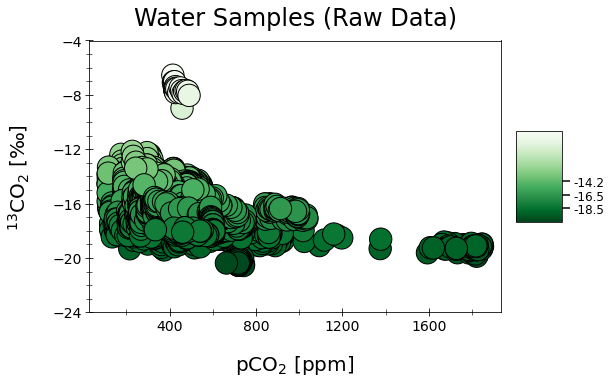

In [5]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Water Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = water['ico2_w'].quantile(0.02)
vmax = water['ico2_w'].quantile(0.98)
mean_value = water['ico2_w'].mean()

mappable = ax.scatter(water['co2_w'], water['ico2_w'], cmap = 'Greens_r', c = water['ico2_w'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1) #,vmin=vmin, vmax=vmax

#ax.axvline(1200, color='grey', ls='--',lw=1.2)
#ax.axhline(-22, color='black', ls='--', lw=1.2)
#ax.axhline(-10, color='black', ls='--', lw=1.2)

#ax.set_xlim(-1,32)
ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('zYenisey_EDA_Raw_co2_ico2_water1.png', dpi = 600, bbox_inches='tight')

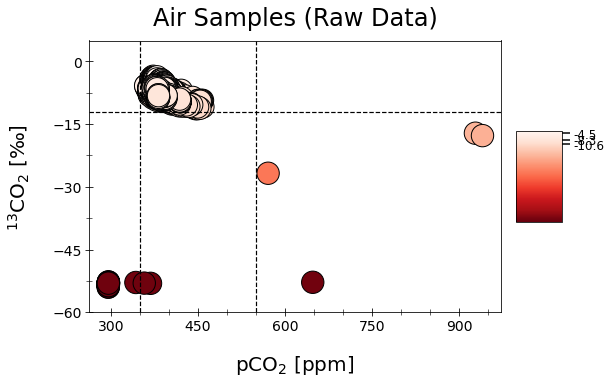

In [6]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Air Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = air['ico2_a'].quantile(0.02)
vmax = air['ico2_a'].quantile(0.98)
mean_value = air['ico2_a'].mean()

mappable = ax.scatter(air['co2_a'], air['ico2_a'], cmap = 'Reds_r', c = air['ico2_a'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1) #, vmin=vmin, vmax=vmax

ax.set_ylim(-60,5)
ax.axhline(-12, color='black', ls='--',lw=1.2)
ax.axvline(350, color='black', ls='--',lw=1.2)
ax.axvline(550, color='black', ls='--',lw=1.2)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('zYenisey_EDA_Raw_co2_ico2_air.png', dpi = 600, bbox_inches='tight')

In [7]:
print(water.shape)
print(air.shape)

(11965, 23)
(3216, 23)


In [8]:
# Move Anomalies to a new dataframe
water_anomalies_co2_w = water[water['co2_w'] > 1197] # 1200
water_anomalies_ico2_w = water[water['ico2_w'] >= -10]
water_anomalies_ch4_w = water[water['ch4_w'] > 500]

air_anomalies_ico2_a = air[air['ico2_a'] <= -12]
air_anomalies_co2_a1 = air[air['co2_a'] > 550]
air_anomalies_co2_a2 = air[air['co2_a'] < 350]
air_anomalies_ch4_a = air[air['ch4_a'] < 1.6]

# Concatenate all the anomalies into a single dataframe
water_anomalies = pd.concat([water_anomalies_ico2_w], axis=0)
air_anomalies = pd.concat([air_anomalies_ico2_a, air_anomalies_co2_a1, air_anomalies_co2_a2], axis=0)

# Remove Anomalies from Origional Dataframe
#water = water[~water.index.isin(water_anomalies_co2_w.index)]
water = water[~water.index.isin(water_anomalies_ico2_w.index)]
air = air[~air.index.isin(air_anomalies_ico2_a.index)]
air = air[~air.index.isin(air_anomalies_co2_a1.index)]
air = air[~air.index.isin(air_anomalies_co2_a2.index)]

In [9]:
# Set Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')

# Function to remove rows from a dataframe based on multiple csv files
def remove_anomalies(main_df, anomaly_file):
    # Import the anomaly DataFrame
    anomaly_df = pd.read_csv(anomaly_file, parse_dates=['date_time'])
    anomaly_df.set_index('date_time', inplace=True)

    # Remove rows in main_df that match rows in anomaly_df
    return main_df[~main_df.index.isin(anomaly_df.index)]

In [10]:
print(water.shape)

# List of anomaly CSV files
anomaly_files = ['chomiak_yenisey_water_ntc_lake1.csv', 
                 'chomiak_yenisey_water_ntc_lake2.csv',
                 'gdf1w_nt.csv', 'gdf1w_pt.csv', 
                 'gdf2w_nt.csv', 'gdf2w_pt.csv']

# Assuming your main DataFrame is 'water' and its index is already set to 'date_time'
for anomaly_file in anomaly_files:
    water = remove_anomalies(water, anomaly_file)
    
print(water.shape)

(11939, 23)
(11093, 23)


In [11]:
print(air.shape)

# List of anomaly CSV files
anomaly_files = ['gdf1a_nt.csv', 'gdf1a_pt.csv', 
                 'gdf2a_nt.csv', 'gdf2a_pt.csv']

# Assuming your main DataFrame is 'air' and its index is already set to 'date_time'
for anomaly_file in anomaly_files:
    air = remove_anomalies(air, anomaly_file)
    
print(air.shape)


(3176, 23)
(3116, 23)


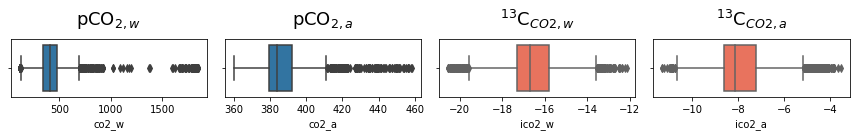

In [12]:
# Set figure and axes
fig, ax = plt.subplots(1,4,figsize =(12,2))

# Box plot
sns.boxplot(x=water['co2_w'], ax=ax[0])
sns.boxplot(x=air['co2_a'], ax=ax[1])
sns.boxplot(x=water['ico2_w'], ax=ax[2], color='tomato')
sns.boxplot(x=air['ico2_a'], ax=ax[3], color='tomato')
# Titles
ax[0].set_title('pCO$_{2,w}$', fontsize=18, pad=15)
ax[1].set_title('pCO$_{2,a}$', fontsize=18, pad=15)
ax[2].set_title('$^{13}$C$_{CO2,w}$', fontsize=18, pad=15)
ax[3].set_title('$^{13}$C$_{CO2,a}$', fontsize=18, pad=15)
fig.tight_layout()

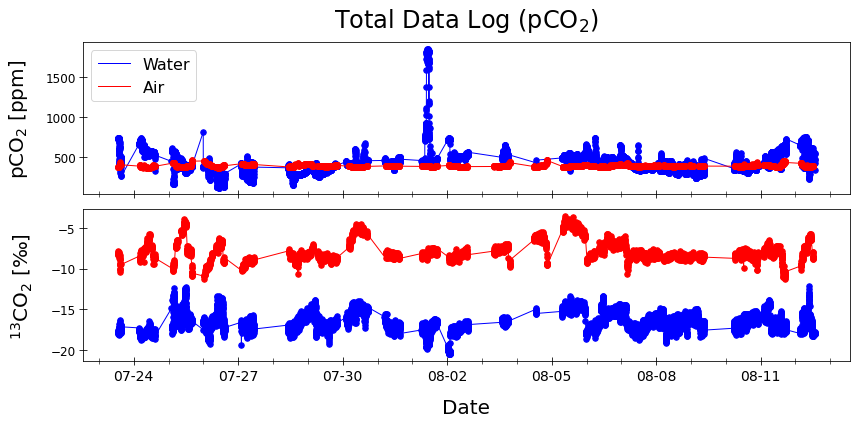

In [13]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
ax[0].set_title('Total Data Log (pCO$_{2}$)', color='black', fontsize=24, pad=15)
ax[0].set_ylabel('pCO$_{2}$ [ppm]', color='black', fontsize=20, labelpad=15)
ax[1].set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[1].set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax[0].plot(water.index, water['co2_w'], c = 'blue', lw=1, label="Water", zorder=0)  # pCO$_{2,water}$
ax[0].plot(air.index, air['co2_a'], c = 'red', lw=1, label="Air", zorder=1)         # pCO$_{2,air}$

ax[0].scatter(water.index, water['co2_w'], c = 'blue', lw=1, s=30, zorder=0)  
ax[0].scatter(air.index, air['co2_a'], c = 'red', lw=1, s=30, zorder=1)  

ax[1].plot(water.index, water['ico2_w'], c = 'blue', lw=1, zorder=0)  # $^{13}$CO$_{2,water}$
ax[1].plot(air.index, air['ico2_a'], c = 'red', lw=1, zorder=1)       # $^{13}$CO$_{2,air}$

ax[1].scatter(water.index, water['ico2_w'], c = 'blue', lw=1, s=30, zorder=0)  
ax[1].scatter(air.index, air['ico2_a'], c = 'red', lw=1, s=30, zorder=1)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
ax[0].legend(fontsize=16, loc='upper left') # bbox_to_anchor=(1.0, 1.00)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
    ax.yaxis.set_major_locator(MaxNLocator(4)) 
    #ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
    #ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
    
fig.tight_layout()
fig.savefig('zYenisey_EDA_Clean_co2_ico2_time.png', dpi = 500, bbox_inches='tight')

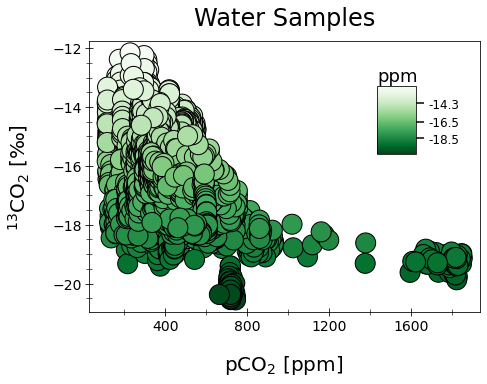

In [14]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_title('Water Samples', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = water['ico2_w'].quantile(0.02)
vmax = water['ico2_w'].quantile(0.98)
mean_value = water['ico2_w'].mean()

m1 = ax.scatter(water['co2_w'], water['ico2_w'], cmap = 'Greens_r', c = water['ico2_w'], 
                      edgecolor= 'black', lw=1.0, s=400, zorder=1)
# vmin=vmin, vmax=vmax
#ax.set_xlim(-1,32)
#ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

#ax.set_xlim(-1,32)
#ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Create an inset axes for the colorbar in the upper right corner of the main plot
# The inset axes size is 10% of the width and 25% of the height of the main axes
# The bbox_to_anchor and bbox_transform parameters position the inset axes relative to the main axes
cb_ax = inset_axes(ax, 
                    width="10%", height="25%", loc='upper right', 
                    bbox_to_anchor=(-0.15, -0.15, 1, 1), bbox_transform=ax.transAxes)

# Add a colorbar to the inset axes, associated with the mappable object (e.g., scatter plot) 'm1'
cb = plt.colorbar(m1, cax=cb_ax)
# Set specific ticks on the colorbar at the minimum, mean, and maximum values of the data
cb.set_ticks([vmin, mean_value, vmax])
# Customize the tick labels with formatted strings to one decimal place
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
# Configure the appearance of the colorbar ticks (length, width, label size)
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12)
# Adjust the position of the colorbar label relative to the colorbar
cb.ax.yaxis.set_label_coords(0.000, 1.15)
# Set the label for the colorbar with a specific font size and label padding
cb.set_label(r'ppm')
# Set the rotation, font size, horizontal and vertical alignment of the colorbar label
cb.ax.set_ylabel(cb.ax.get_ylabel(), rotation=0, fontsize=18, ha='left', va='center')

os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zYenisey_EDA_Clean_co2_ico2_water.png', dpi = 500, bbox_inches='tight')

In [15]:
mean1, std1 = water['co2_w'].mean(), water['co2_w'].std()
print(f'pCO2 = {mean1:.0f} ± {std1:.0f}')
find_min_max_2(water, 'co2_w', 'lat_w')
print()
mean1, std1 = water['ico2_w'].mean(), water['ico2_w'].std()
print(f'13C_CO2 = {mean1:.1f} ± {std1:.1f}')
find_min_max_2(water, 'ico2_w', 'lat_w')

pCO2 = 425 ± 154
Min co2_w @ 115.4 on 2016-07-26 10:33:00 @ lat_w: 60.000661
Max co2_w @ 1848.5 on 2016-08-01 10:25:00 @ lat_w: 65.92985375

13C_CO2 = -16.5 ± 1.1
Min ico2_w @ -20.6 on 2016-08-02 01:20:00 @ lat_w: 66.49677992
Max ico2_w @ -12.2 on 2016-08-12 09:09:00 @ lat_w: 58.13089281


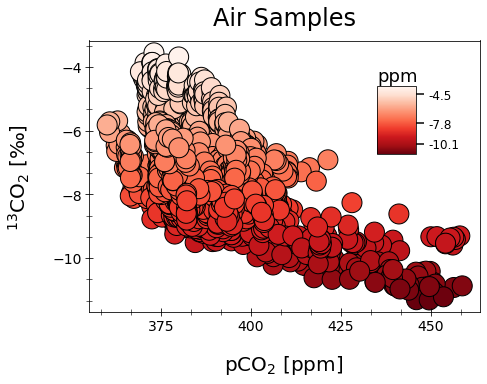

In [16]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_title('Air Samples', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = air['ico2_a'].quantile(0.02)
vmax = air['ico2_a'].quantile(0.98)
mean_value = air['ico2_a'].mean()

m1 = ax.scatter(air['co2_a'], air['ico2_a'], cmap = 'Reds_r', c = air['ico2_a'], 
                      edgecolor= 'black', lw=1.0, s=400, zorder=1) # , vmin=vmin, vmax=vmax

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(3))
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

cb_ax = inset_axes(ax, 
                    width="10%", height="25%", loc='upper right', 
                    bbox_to_anchor=(-0.15, -0.15, 1, 1), bbox_transform=ax.transAxes)

# Add a colorbar to the inset axes, associated with the mappable object (e.g., scatter plot) 'm1'
cb = plt.colorbar(m1, cax=cb_ax)
# Set specific ticks on the colorbar at the minimum, mean, and maximum values of the data
cb.set_ticks([vmin, mean_value, vmax])
# Customize the tick labels with formatted strings to one decimal place
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
# Configure the appearance of the colorbar ticks (length, width, label size)
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12)
# Adjust the position of the colorbar label relative to the colorbar
cb.ax.yaxis.set_label_coords(0.000, 1.15)
# Set the label for the colorbar with a specific font size and label padding
cb.set_label(r'ppm')
# Set the rotation, font size, horizontal and vertical alignment of the colorbar label
cb.ax.set_ylabel(cb.ax.get_ylabel(), rotation=0, fontsize=18, ha='left', va='center')

os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zYenisey_EDA_Clean_co2_ico2_air.png', dpi = 500, bbox_inches='tight')

In [17]:
mean1, std1 = air['co2_a'].mean(), air['co2_a'].std()
print(f'{mean1:.0f} ± {std1:.0f}')
find_min_max_2(air, 'co2_a', 'lat_a')
print()
mean1, std1 = air['ico2_a'].mean(), air['ico2_a'].std()
print(f'13C_CO2 = {mean1:.1f} ± {std1:.1f}')
find_min_max_2(air, 'ico2_a', 'lat_a')

387 ± 14
Min co2_a @ 360.0 on 2016-07-24 11:20:00 @ lat_a: 57.65708175
Max co2_a @ 458.7 on 2016-07-25 16:15:00 @ lat_a: 59.09764958

13C_CO2 = -7.8 ± 1.3
Min ico2_a @ -11.3 on 2016-08-11 16:43:00 @ lat_a: 58.51843408
Max ico2_a @ -3.6 on 2016-08-05 08:55:00 @ lat_a: 67.17382367


In [18]:
print(water['co2_w'].count())
print(air['co2_a'].count())

11093
3116


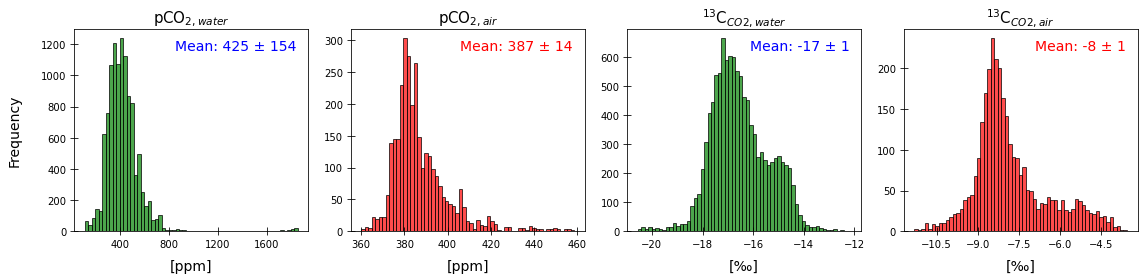

In [19]:
fig, ax = plt.subplots(1,4, figsize=(16, 4))

# Data for the first subplot
data_1 = water['co2_w']
mean, std = water['co2_w'].mean(), water['co2_w'].std()
ax[0].hist(data_1, bins=61, edgecolor='black', color='green', alpha=0.7)
ax[0].set_title('pCO$_{2,water}$', fontsize=15)
ax[0].set_ylabel('Frequency', labelpad=20, fontsize=14)
ax[0].set_xlabel(r'[ppm]', labelpad=10, fontsize=14)
ax[0].text(0.95, 0.95, f'Mean: {mean:.0f} ± {std:.0f}', fontsize=14, color='blue',ha='right', va='top', transform=ax[0].transAxes)

# Data for the first subplot
data_2 = air['co2_a']
mean, std = air['co2_a'].mean(), air['co2_a'].std()
ax[1].hist(data_2, bins=61, edgecolor='black', color='red', alpha=0.7)
ax[1].set_title('pCO$_{2,air}$', fontsize=15)
ax[1].set_xlabel(r'[ppm]', labelpad=10, fontsize=14)
ax[1].text(0.95, 0.95, f'Mean: {mean:.0f} ± {std:.0f}', fontsize=14, color='red', ha='right', va='top', transform=ax[1].transAxes)

# Data for the first subplot
data_3 = water['ico2_w']
mean, std = water['ico2_w'].mean(), water['ico2_w'].std()
ax[2].hist(data_3, bins=61, edgecolor='black', color='green', alpha=0.7)
ax[2].set_title('$^{13}$C$_{CO2, water}$', fontsize=15)
ax[2].set_xlabel(r'[‰]', labelpad=10, fontsize=14)
ax[2].text(0.95, 0.95, f'Mean: {mean:.0f} ± {std:.0f}', fontsize=14, color='blue',ha='right', va='top', transform=ax[2].transAxes)

# Data for the first subplot
data_4 = air['ico2_a']
mean, std = air['ico2_a'].mean(), air['ico2_a'].std()
ax[3].hist(data_4, bins=61, edgecolor='black', color='red', alpha=0.7)
ax[3].set_title('$^{13}$C$_{CO2, air}$', fontsize=15)
ax[3].set_xlabel(r'[‰]', labelpad=10, fontsize=14)
ax[3].text(0.95, 0.95, f'Mean: {mean:.0f} ± {std:.0f}', fontsize=14, color='red',ha='right', va='top', transform=ax[3].transAxes)


for ax in ax:
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

fig.tight_layout()

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zhist_co2_ico2.png', dpi = 600, bbox_inches='tight')

### Correlations

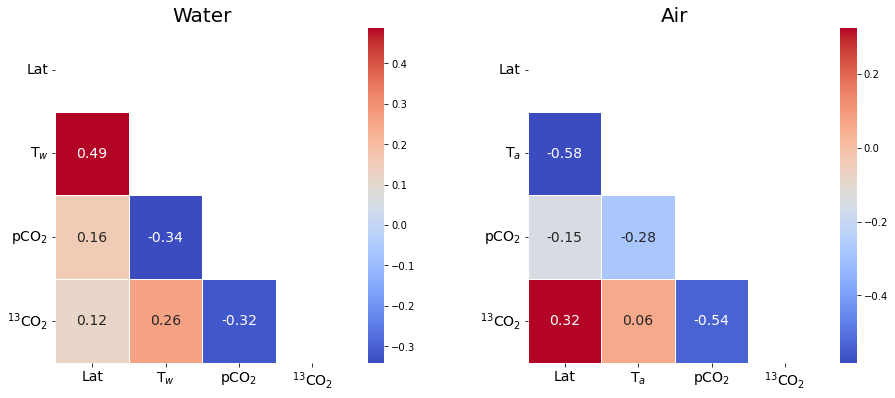

In [20]:
water_new = water[['lat_w', 't_adcp_w',  'co2_w','ico2_w']]
air_new = air[['lat_a',  't_rad_a', 'co2_a',  'ico2_a']]

# Rename Columns
water_new.columns = ['Lat', 'T$_{w}$', 'pCO$_{2}$', '$^{13}$CO$_{2}$']
air_new.columns = ['Lat', 'T$_{a}$', 'pCO$_{2}$', '$^{13}$CO$_{2}$']

# Calculate the correlation matrix for the entire DataFrame
correlation_matrix_water = water_new.corr()
correlation_matrix_air = air_new.corr()

# Create a mask for the upper triangle
mask_water = np.triu(np.ones_like(correlation_matrix_water, dtype=bool))
mask_air = np.triu(np.ones_like(correlation_matrix_air, dtype=bool))

# Creating the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Water heatmap
sns.heatmap(correlation_matrix_water, mask=mask_water, ax=ax[0], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 14})
ax[0].set_title('Water', fontsize=20)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14, rotation=0)

# Air heatmap
sns.heatmap(correlation_matrix_air, mask=mask_air, ax=ax[1], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 14})
ax[1].set_title('Air', fontsize=20)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14, rotation=0)

fig.tight_layout(pad=6)

fig.savefig('zYenisey_EDA_Clean_correlation_matrix_CO2.png', dpi = 500, bbox_inches='tight')

### Different Cruises

In [21]:
# Transect I
df1w = water.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
df1a = air.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 

# Transect II
df2w = water.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']
df2a = air.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

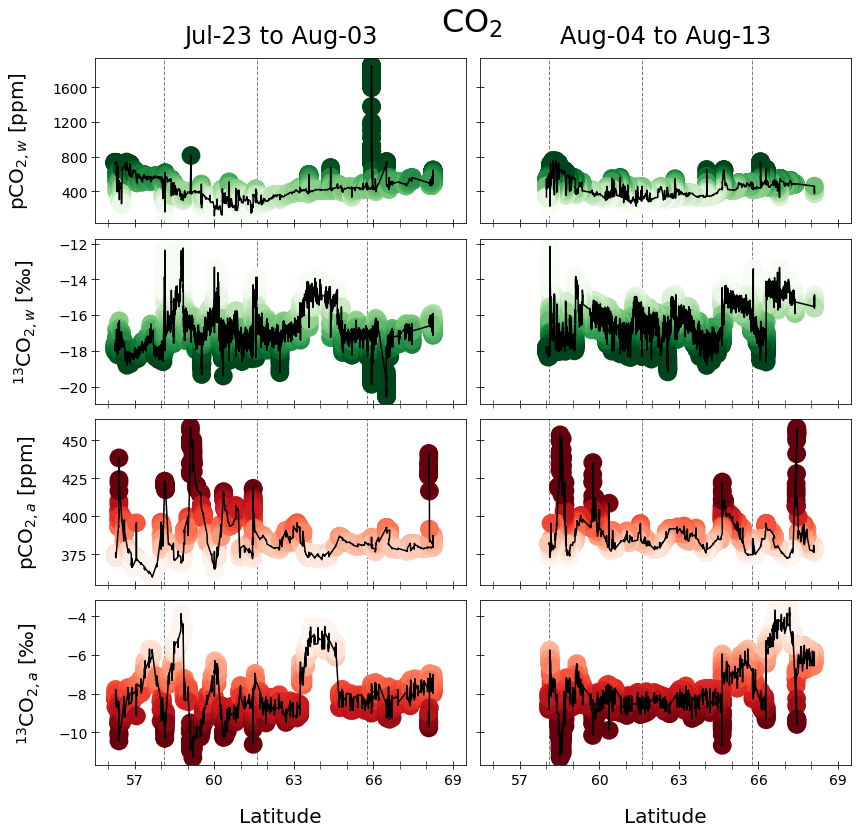

In [22]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['co2_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ico2_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['co2_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ico2_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['co2_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ico2_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['co2_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ico2_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w['lat_w'], df1w['co2_w'], cmap = 'Greens', c = df1w['co2_w'], 
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df1w['co2_w'].quantile(0.05), 
                vmax=df1w['co2_w'].quantile(0.95))

ax[1,0].scatter(df1w['lat_w'], df1w['ico2_w'], cmap = 'Greens_r', c = df1w['ico2_w'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df1w['ico2_w'].quantile(0.05), 
                vmax=df1w['ico2_w'].quantile(0.95))

ax[2,0].scatter(df1a['lat_a'], df1a['co2_a'], cmap = 'Reds', c = df1a['co2_a'], 
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df1a['co2_a'].quantile(0.05), 
                vmax=df1a['co2_a'].quantile(0.95))

ax[3,0].scatter(df1a['lat_a'], df1a['ico2_a'], cmap = 'Reds_r', c = df1a['ico2_a'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df1a['ico2_a'].quantile(0.05), 
                vmax=df1a['ico2_a'].quantile(0.95))

ax[0,1].scatter(df2w['lat_w'], df2w['co2_w'], cmap = 'Greens', c = df2w['co2_w'], 
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df2w['co2_w'].quantile(0.05), 
                vmax=df2w['co2_w'].quantile(0.95))

ax[1,1].scatter(df2w['lat_w'], df2w['ico2_w'], cmap = 'Greens_r', c = df2w['ico2_w'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df2w['ico2_w'].quantile(0.05), 
                vmax=df2w['ico2_w'].quantile(0.95))

ax[2,1].scatter(df2a['lat_a'], df2a['co2_a'], cmap = 'Reds', c = df2a['co2_a'], 
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df2a['co2_a'].quantile(0.05), 
                vmax=df2a['co2_a'].quantile(0.95))

ax[3,1].scatter(df2a['lat_a'], df2a['ico2_a'], cmap = 'Reds_r', c = df2a['ico2_a'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df2a['ico2_a'].quantile(0.05), 
                vmax=df2a['ico2_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCO$_{2,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCO$_{2,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CO$_{2,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CO$_{2,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    #ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.suptitle('CO$_2$', fontsize=32, x=0.55, y=0.96)

fig.tight_layout(pad=1)

fig.savefig('zYenisey_EDA_co2_Latitude.png', dpi = 600, bbox_inches='tight')

In [23]:
mean1 = df1w['co2_w'].mean()
std1 = df1w['co2_w'].std()
print(f'{mean1:.0f} ± {std1:.0f}')
find_min_max_2(df1w, 'co2_w', 'lat_w')
print()
mean1 = df1w['ico2_w'].mean()
std1 = df1w['ico2_w'].std()
print(f'{mean1:.1f} ± {std1:.1f}')
find_min_max_2(df1w, 'ico2_w', 'lat_w')

425 ± 197
Min co2_w @ 115.4 on 2016-07-26 10:33:00 @ lat_w: 60.000661
Max co2_w @ 1848.5 on 2016-08-01 10:25:00 @ lat_w: 65.92985375

-16.8 ± 1.2
Min ico2_w @ -20.6 on 2016-08-02 01:20:00 @ lat_w: 66.49677992
Max ico2_w @ -12.3 on 2016-07-25 12:07:00 @ lat_w: 58.82045942


In [24]:
mean1 = df2w['co2_w'].mean()
std1 = df2w['co2_w'].std()
print(f'{mean1:.0f} ± {std1:.0f}')
find_min_max_2(df2w, 'co2_w', 'lat_w')
print()
mean1 = df2w['ico2_w'].mean()
std1 = df2w['ico2_w'].std()
print(f'{mean1:.1f} ± {std1:.1f}')
find_min_max_2(df2w, 'ico2_w', 'lat_w')

424 ± 96
Min co2_w @ 227.2 on 2016-08-12 09:09:00 @ lat_w: 58.13089281
Max co2_w @ 752.0 on 2016-08-12 05:34:00 @ lat_w: 58.35815442

-16.3 ± 1.0
Min ico2_w @ -19.2 on 2016-08-08 06:44:00 @ lat_w: 62.57857333
Max ico2_w @ -12.2 on 2016-08-12 09:09:00 @ lat_w: 58.13089281


In [25]:
def aggregate_stats(df, freq):
    """
    Aggregates statistics (mean, standard deviation, maximum, minimum) 
    for all numeric columns in a DataFrame, grouping the data by a specified frequency.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    freq (str): The frequency string to group the data.

    Returns:
    pd.DataFrame: A DataFrame containing the aggregated statistics for each numeric column.
    """
    # Filter out non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Group by and calculate statistics
    df_mean = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).mean()
    df_std = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).std().add_suffix('_std')
    df_max = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).max().add_suffix('_max')
    df_min = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).min().add_suffix('_min')
    
    # Concatenate results along the columns axis
    result = pd.concat([df_mean, df_std, df_max, df_min], axis=1)
    
    return result

In [26]:
# 30TR Groupby
df1w_30T = aggregate_stats(df1w, freq='30T')
df2w_30T = aggregate_stats(df2w, freq='30T')

# 30TR Groupby
df1a_30T = aggregate_stats(df1a, freq='30T')
df2a_30T = aggregate_stats(df2a, freq='30T')

# Shape
print()
print('-----------------------------------------------------')
print(water.shape, '@ Water')
print('-----------------------------------------------------')
print(air.shape, '@ Water')
print('-----------------------------------------------------')
print(df1w_30T.shape, ' @ 30T @ Water I')
print(df2w_30T.shape, ' @ 30T @ Water II')
print('-----------------------------------------------------')
print(df1a_30T.shape, ' @ 30T @ Air I')
print(df2a_30T.shape, ' @ 30T @ Air II')
print('-----------------------------------------------------')
print()


-----------------------------------------------------
(11093, 23) @ Water
-----------------------------------------------------
(3116, 23) @ Water
-----------------------------------------------------
(538, 88)  @ 30T @ Water I
(385, 88)  @ 30T @ Water II
-----------------------------------------------------
(541, 88)  @ 30T @ Air I
(386, 88)  @ 30T @ Air II
-----------------------------------------------------



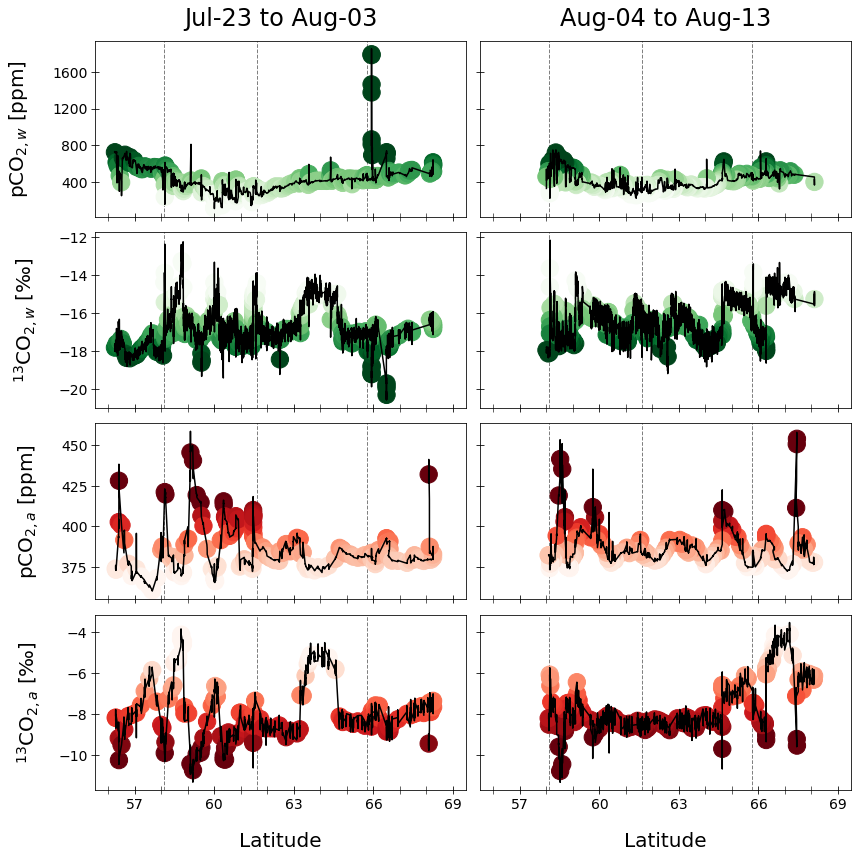

In [27]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['co2_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ico2_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['co2_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ico2_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['co2_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ico2_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['co2_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ico2_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w_30T['lat_w'], df1w_30T['co2_w'], cmap = 'Greens', c = df1w_30T['co2_w'], 
                s=300, label="pCO$_{2,water}$", 
                vmin=df1w_30T['co2_w'].quantile(0.05), 
                vmax=df1w_30T['co2_w'].quantile(0.95))

ax[1,0].scatter(df1w_30T['lat_w'], df1w_30T['ico2_w'], cmap = 'Greens_r', c = df1w_30T['ico2_w'], 
                s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df1w_30T['ico2_w'].quantile(0.05), 
                vmax=df1w_30T['ico2_w'].quantile(0.95))

ax[2,0].scatter(df1a_30T['lat_a'], df1a_30T['co2_a'], cmap = 'Reds', c = df1a_30T['co2_a'], 
                s=300, label="pCO$_{2,air}$",
                vmin=df1a_30T['co2_a'].quantile(0.05), 
                vmax=df1a_30T['co2_a'].quantile(0.95))

ax[3,0].scatter(df1a_30T['lat_a'], df1a_30T['ico2_a'], cmap = 'Reds_r', c = df1a_30T['ico2_a'],
                s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df1a_30T['ico2_a'].quantile(0.05), 
                vmax=df1a_30T['ico2_a'].quantile(0.95))

ax[0,1].scatter(df2w_30T['lat_w'], df2w_30T['co2_w'], cmap = 'Greens', c = df2w_30T['co2_w'], 
                s=300, label="pCO$_{2,water}$", 
                vmin=df2w_30T['co2_w'].quantile(0.05), 
                vmax=df2w_30T['co2_w'].quantile(0.95))

ax[1,1].scatter(df2w_30T['lat_w'], df2w_30T['ico2_w'], cmap = 'Greens_r', c = df2w_30T['ico2_w'], 
                s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df2w_30T['ico2_w'].quantile(0.05), 
                vmax=df2w_30T['ico2_w'].quantile(0.95))

ax[2,1].scatter(df2a_30T['lat_a'], df2a_30T['co2_a'], cmap = 'Reds', c = df2a_30T['co2_a'], 
                s=300, label="pCO$_{2,air}$",
                vmin=df2a_30T['co2_a'].quantile(0.05), 
                vmax=df2a_30T['co2_a'].quantile(0.95))

ax[3,1].scatter(df2a_30T['lat_a'], df2a_30T['ico2_a'], cmap = 'Reds_r', c = df2a_30T['ico2_a'], 
                lw=1, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df2a_30T['ico2_a'].quantile(0.05), 
                vmax=df2a_30T['ico2_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCO$_{2,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCO$_{2,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CO$_{2,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CO$_{2,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    #ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.tight_layout(pad=1)

fig.savefig('zYenisey_EDA_30T_co2_Latitude.png', dpi = 600, bbox_inches='tight')

In [28]:
# Dictionary Water II
df1w_30T['date'] = df1w_30T.index.date
df1w_30T = df1w_30T.dropna()
# Group the data by each day
group_water = df1w_30T.groupby('date')
# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_water = {str(day): group for day, group in group_water}

# Dictionary Air II
df1a_30T['date'] = df1a_30T.index.date
df1a_30T = df1a_30T.dropna()
# Group the data by each day
group_air = df1a_30T.groupby('date')
# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_air = {str(day): group for day, group in group_air}

# Calculate the number of subplots needed
num_subplots = len(group_water)
# Calculate the number of columns for the subplot grid (fixed at 4)
num_cols = 4
# Calculate the number of rows for the subplot grid and Round up the division result to the nearest integer
num_rows = -(-num_subplots // num_cols)  # Using -(-x // y) for ceiling division

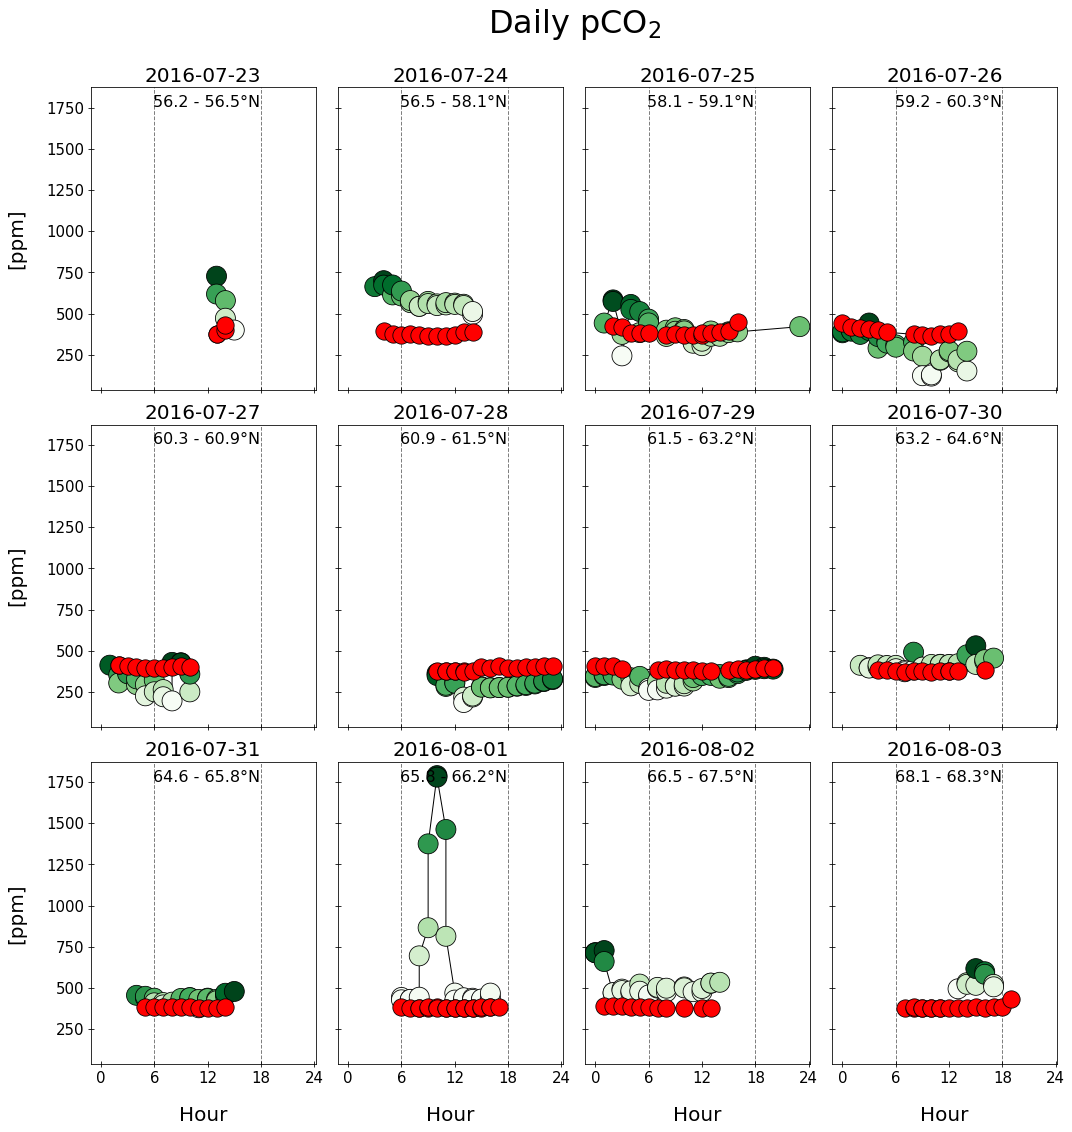

In [29]:
num_subplots# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_water):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_w'], cmap = 'Greens', c = group['co2_w'],
               lw=0.8, s=400, edgecolor='black', zorder=2,)  
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    #ax.set_ylim(50, 1100)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_air):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_a'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_a'], c = 'red',lw=0.8, s=300, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily pCO$_{2}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zChomiak_Daily_30min_co2w_I.png', dpi = 600, bbox_inches='tight')

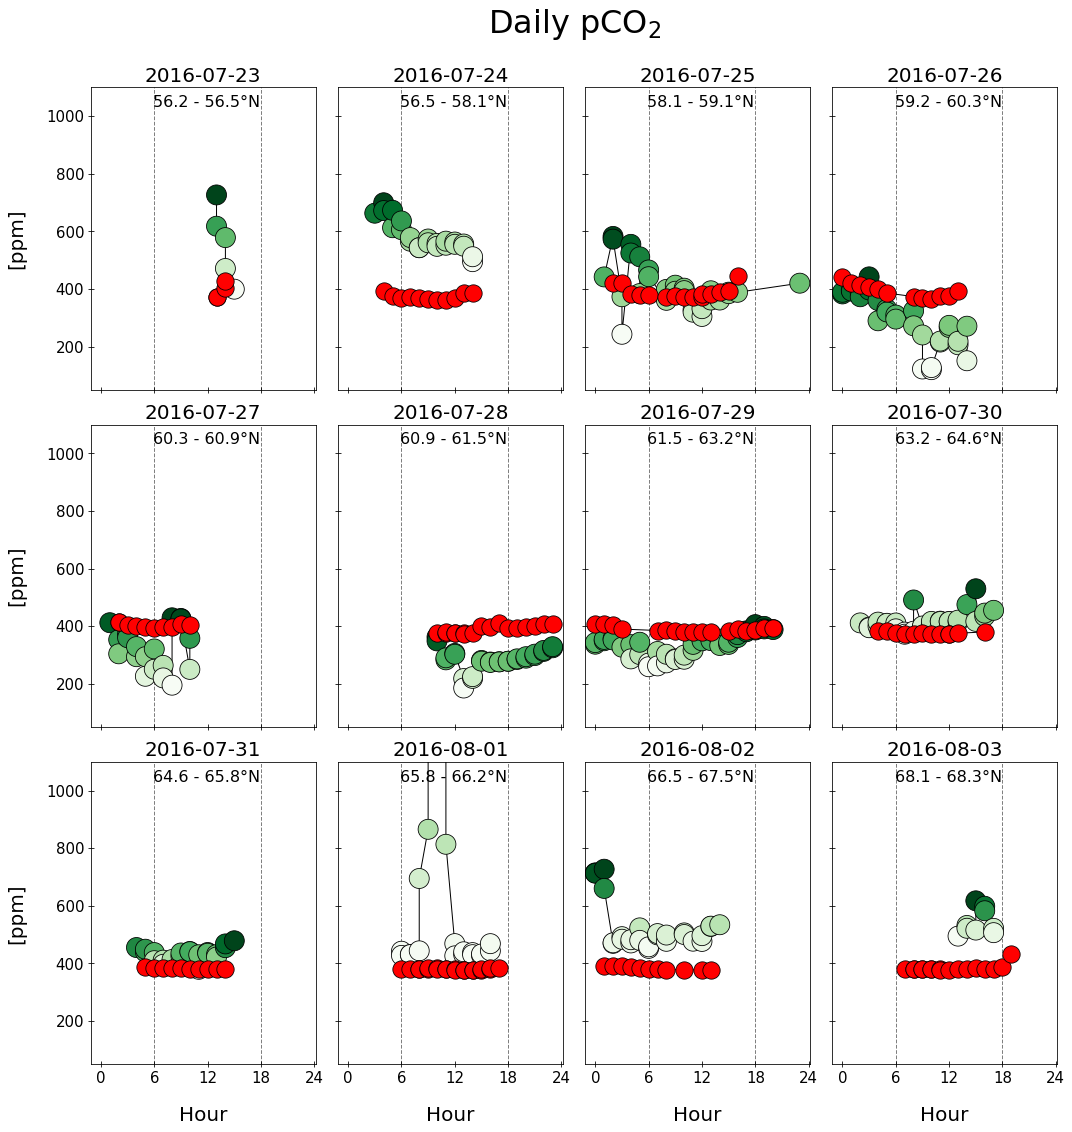

In [30]:
num_subplots# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_water):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_w'], cmap = 'Greens', c = group['co2_w'],
               lw=0.8, s=400, edgecolor='black', zorder=2,)  
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    ax.set_ylim(50, 1100)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_air):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_a'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_a'], c = 'red',lw=0.8, s=300, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily pCO$_{2}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zChomiak_Daily_30min_co2w_I_lim.png', dpi = 600, bbox_inches='tight')

In [31]:
# Dictionary Water II
df2w_30T['date'] = df2w_30T.index.date
df2w_30T = df2w_30T.dropna()
# Group the data by each day
group_water = df2w_30T.groupby('date')
# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_water = {str(day): group for day, group in group_water}

# Dictionary Air II
df2a_30T['date'] = df2a_30T.index.date
df2a_30T = df2a_30T.dropna()
# Group the data by each day
group_air = df2a_30T.groupby('date')
# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_air = {str(day): group for day, group in group_air}

# Calculate the number of subplots needed
num_subplots = len(group_water)
# Calculate the number of columns for the subplot grid (fixed at 4)
num_cols = 4
# Calculate the number of rows for the subplot grid and Round up the division result to the nearest integer
num_rows = -(-num_subplots // num_cols)  # Using -(-x // y) for ceiling division

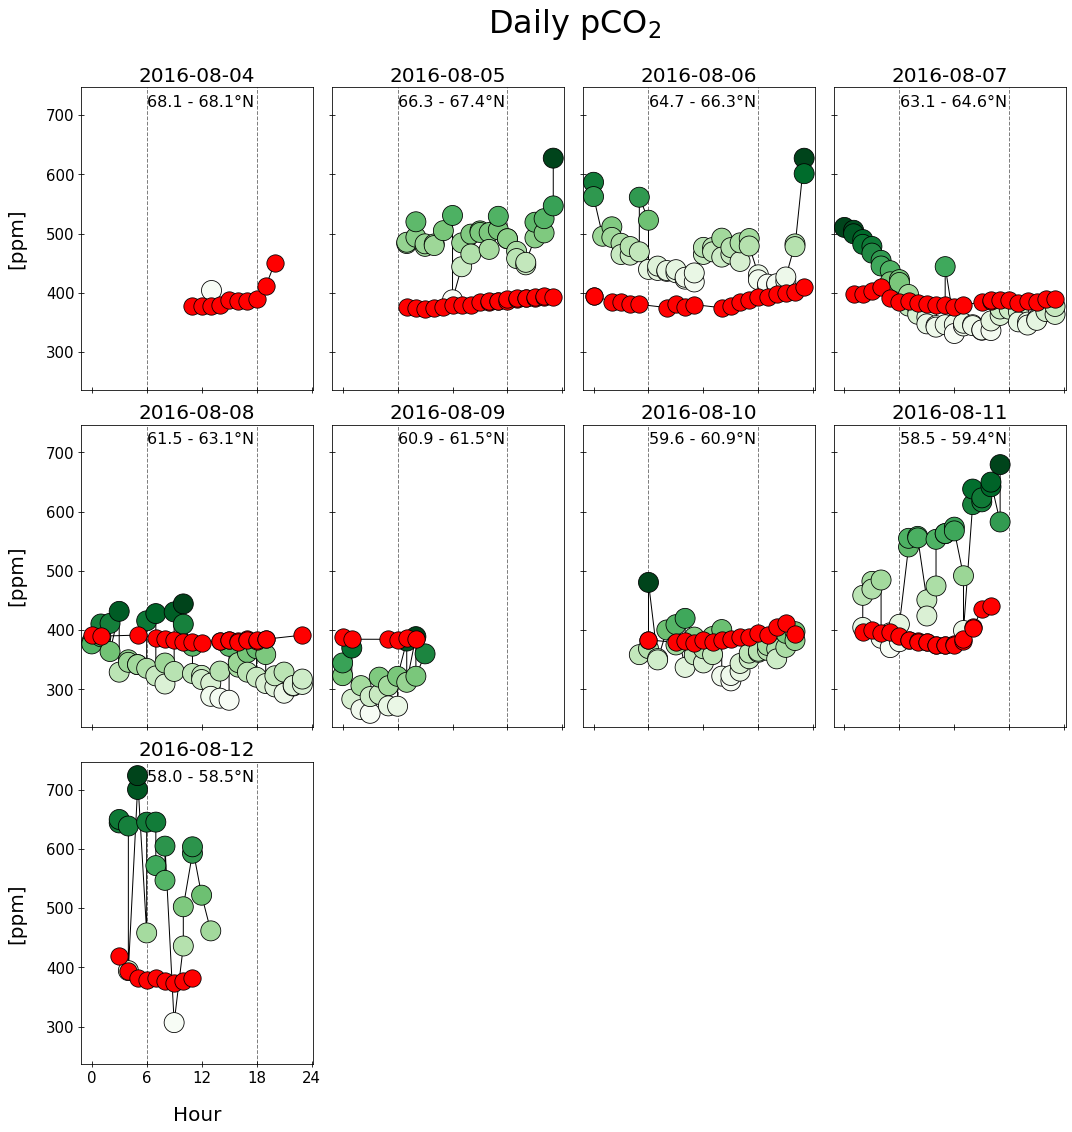

In [32]:
num_subplots# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_water):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_w'], cmap = 'Greens', c = group['co2_w'],
               lw=0.8, s=400, edgecolor='black', zorder=2,)  
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    #ax.set_ylim(50, 1100)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_air):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_a'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_a'], c = 'red',lw=0.8, s=300, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily pCO$_{2}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zChomiak_Daily_30min_co2w_II.png', dpi = 600, bbox_inches='tight')

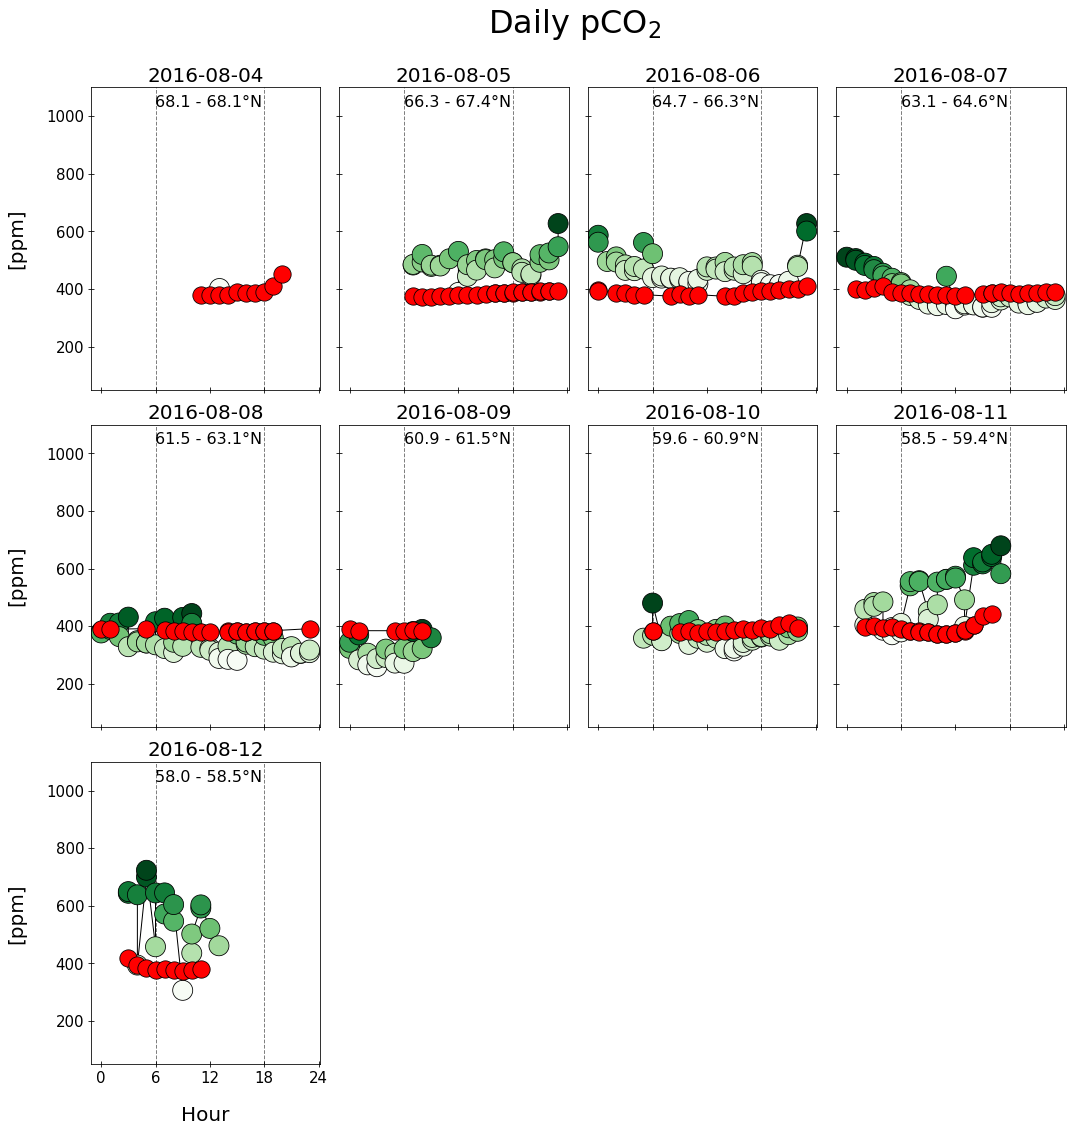

In [33]:
num_subplots# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_water):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_w'], cmap = 'Greens', c = group['co2_w'],
               lw=0.8, s=400, edgecolor='black', zorder=2,)  
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    ax.set_ylim(50, 1100)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Iterate over the group_water and create subplots
for i, (day, group) in enumerate(group_air):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_a'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_a'], c = 'red',lw=0.8, s=300, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily pCO$_{2}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zChomiak_Daily_30min_co2w_II_lim.png', dpi = 600, bbox_inches='tight')

In [34]:
import geopandas as gpd
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')
# Yenisey Watershed
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Yenisey Lakes
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

# Open the dictionary with pickle
with open('watersheds_gdfs_grouped.pkl', 'rb') as file:
    watersheds_gdfs_grouped = pickle.load(file)

# Open River Dictionary
with open('clipped_rivers_by_watershed.pkl', 'rb') as file:
    # Load the dictionary from the file
    clipped_rivers_by_watershed = pickle.load(file)
print("Dictionary loaded successfully.")

# Key Tributaries (Watershed)
krasno = watersheds_gdfs_grouped['w_3226']
angara = watersheds_gdfs_grouped['w_3227']
angara_confluence = watersheds_gdfs_grouped['w_3225']
pt = watersheds_gdfs_grouped['w_3224']
pt_confluence = watersheds_gdfs_grouped['w_3223']
nt = watersheds_gdfs_grouped['w_3222']
nt_confluence = watersheds_gdfs_grouped['w_3221']

# Key Tributaries (River Lines)
rkrasno = clipped_rivers_by_watershed['w_3226']
rangara = clipped_rivers_by_watershed['w_3227']
rangara_confluence = clipped_rivers_by_watershed['w_3225']
rpt = clipped_rivers_by_watershed['w_3224']
rpt_confluence = clipped_rivers_by_watershed['w_3223']
rnt = clipped_rivers_by_watershed['w_3222']
rnt_confluence = clipped_rivers_by_watershed['w_3221']

# Color Coordinate for Watersheds
colors = ['darkblue', 'darkviolet', 'darkgreen', 'violet', 'maroon', 'orange', 'peru', 'forestgreen', 'red', 'darkgrey', 
          'lightgrey', 'grey', 'peru', 'sandybrown', 'darkgoldenrod', 'goldenrod', 'palegoldenrod', 'tan', 'navajowhite', 'floralwhite']

PFAF_ID_4d = ['3227', '3222', '3226', '3224', '3221', '3229', '3228', '3225', '3223', '3422', 
              '3429', '3316', '3610', '3428', '3124', '3312', '3136', '3210', '3427', '3230']

color_dict = {pfaf_id: color for pfaf_id, color in zip(PFAF_ID_4d, colors)}

# Colormap
watershed_colors = {}

for watershed_name in clipped_rivers_by_watershed.keys():
    # Extracting the PFAF_ID_4d from the key by stripping the "w_" prefix
    pfaf_id = watershed_name.split("_")[1]
    
    # Getting the color for this PFAF_ID_4d
    watershed_color = color_dict[pfaf_id]
    
    # Storing the color in the new dictionary
    watershed_colors[watershed_name] = watershed_color

Dictionary loaded successfully.


In [35]:
p2 = df1w_30T['co2_w'].quantile(0.02)
p98 = df1w_30T['co2_w'].quantile(0.98)

print(p2,' , ', p98)
print()
# Filter the DataFrame
filtered_df_high = df1w_30T[df1w_30T['co2_w'] > p98]
filtered_df_low = df1w_30T[df1w_30T['co2_w'] < p2]

n = (df1w_30T.shape[0])
print(n)
print()
n1 = filtered_df_high.shape[0]
percent_p2 = (n1/n)*100
print(f'{n1}, {percent_p2:.1f} %')
n2 = filtered_df_high.shape[0]
percent_p98 = (n2/n)*100
print(f'{n2}, {percent_p98:.1f} %')

df1w_30T = df1w_30T.sort_values(by='co2_w', ascending=True)

201.6668901225543  ,  765.3941412707893

279

6, 2.2 %
6, 2.2 %


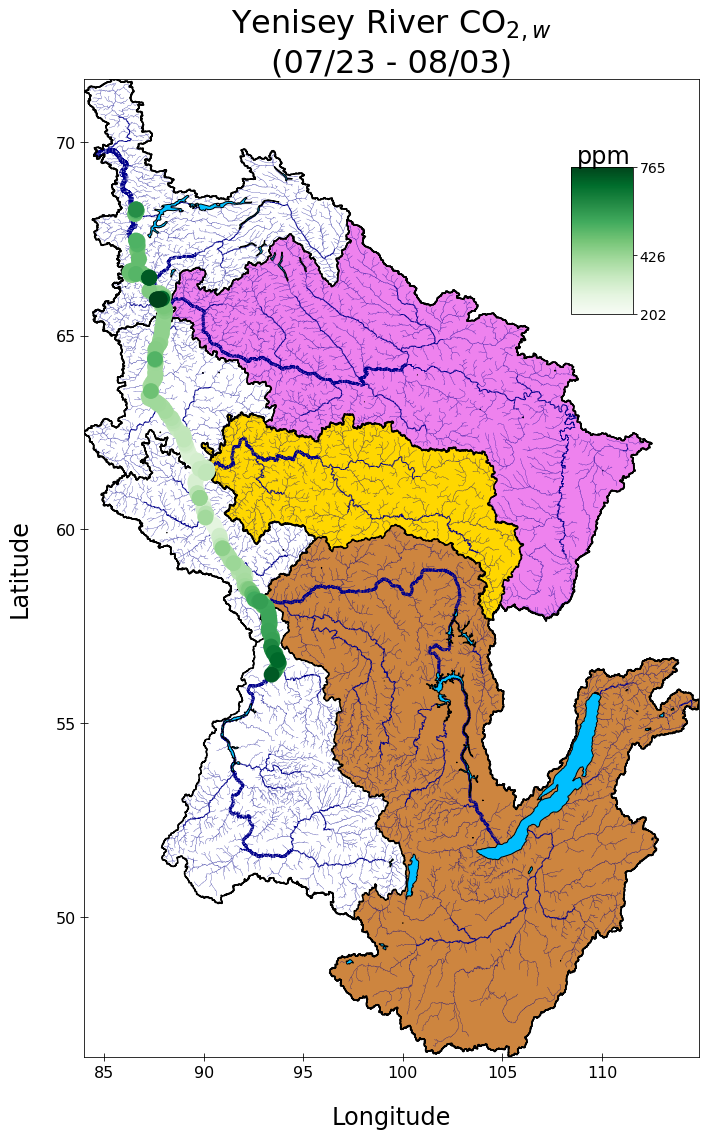

In [36]:
fig, ax = plt.subplots(figsize=(18, 18))

# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 5, 6
        elif flow_order == 3:
            lw, z = 3, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.333, 3
        elif flow_order == 6:
            lw, z = 0.25, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt.plot(ax=ax, color='violet', edgecolor='black', lw=1.5, zorder=0)
pt.plot(ax=ax, color='gold', edgecolor='black', lw=1.5, zorder=0)
angara.plot(ax=ax, color='peru', edgecolor='black', lw=1.5, zorder=0)
nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
gpd_lakes.plot(ax=ax, color='deepskyblue', edgecolor='black', lw=1, zorder=8)
ax.set_title("Yenisey River CO$_{2,w}$\n(07/23 - 08/03)", fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Scatter plot for 'Flux_co2_kg_hr'
#colors = ['steelblue' if value > 0 else 'red' for value in all_data['Flux_co2_kg_m2_hr']]
#ax.scatter(all_data['lon'], all_data['lat'], c=colors, ec='black', lw=0.75, s=250, zorder=9)
#ax.scatter(filtered_df_high['lon'], filtered_df_high['lat'], c='red', ec='black', lw=0.75, s=250, zorder=9)
#ax.scatter(filtered_df_low['lon'], filtered_df_low['lat'], c='steelblue', ec='black', lw=0.75, s=250, zorder=9)

m1 = ax.scatter(df1w_30T['lon_w'], df1w_30T['lat_w'], c=df1w_30T['co2_w'], cmap = 'Greens', 
                vmin = p2, vmax = p98, ec='none', lw=0.75, s=250, zorder=9)


# Colorbar 1
cb_ax1 = inset_axes(ax, width="10%", height="15%", loc='upper right', 
                    bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax.transAxes)
cb1 = plt.colorbar(m1, cax=cb_ax1)
cb1.set_label(r'ppm', fontsize=18, labelpad=15)
cb1.ax.tick_params(labelsize=14)
cb1.set_ticks([df1w_30T['co2_w'].quantile(0.02), 
               df1w_30T['co2_w'].mean(), 
               df1w_30T['co2_w'].quantile(0.98)])
cb1.set_ticklabels(['{:.0f}'.format(df1w_30T['co2_w'].quantile(0.02)), 
                    '{:.0f}'.format(df1w_30T['co2_w'].mean()), 
                    '{:.0f}'.format(df1w_30T['co2_w'].quantile(0.98))])
cb1.ax.yaxis.set_label_coords(0.100, 1.075)  # Adjust the x and y coordinates as needed
cb1.ax.set_ylabel(cb1.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')


# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zCO2_map_1.png', dpi = 600, bbox_inches='tight')

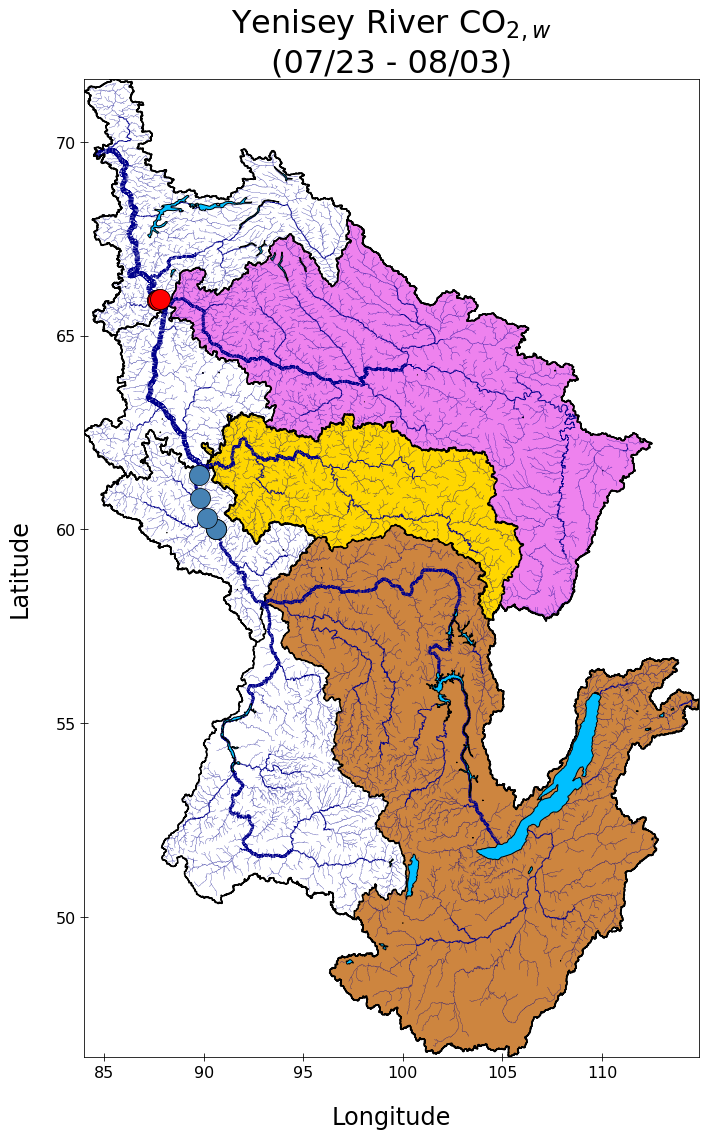

In [37]:
fig, ax = plt.subplots(figsize=(18, 18))

# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 5, 6
        elif flow_order == 3:
            lw, z = 3, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.333, 3
        elif flow_order == 6:
            lw, z = 0.25, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt.plot(ax=ax, color='violet', edgecolor='black', lw=1.5, zorder=0)
pt.plot(ax=ax, color='gold', edgecolor='black', lw=1.5, zorder=0)
angara.plot(ax=ax, color='peru', edgecolor='black', lw=1.5, zorder=0)
nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)

gpd_lakes.plot(ax=ax, color='deepskyblue', edgecolor='black', lw=1, zorder=8)
ax.set_title("Yenisey River CO$_{2,w}$\n(07/23 - 08/03)", fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

ax.scatter(filtered_df_high['lon_w'], filtered_df_high['lat_w'], c='red', ec='black', lw=0.75, s=400, zorder=9)
ax.scatter(filtered_df_low['lon_w'], filtered_df_low['lat_w'], c='steelblue', ec='black', lw=0.75, s=400, zorder=9)

# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zCO2_map_1a.png', dpi = 600, bbox_inches='tight')

In [38]:
p2 = df2w_30T['co2_w'].quantile(0.02)
p98 = df2w_30T['co2_w'].quantile(0.98)

print(p2,' , ', p98)
print()
# Filter the DataFrame
filtered_df_high = df2w_30T[df2w_30T['co2_w'] > p98]
filtered_df_low = df2w_30T[df2w_30T['co2_w'] < p2]

n = (df2w_30T.shape[0])
print(n)
print()
n1 = filtered_df_high.shape[0]
percent_p2 = (n1/n)*100
print(f'{n1}, {percent_p2:.1f} %')
n2 = filtered_df_high.shape[0]
percent_p98 = (n2/n)*100
print(f'{n2}, {percent_p98:.1f} %')

df2w_30T = df2w_30T.sort_values(by='co2_w', ascending=True)

284.4634648435905  ,  645.0445643469232

280

6, 2.1 %
6, 2.1 %


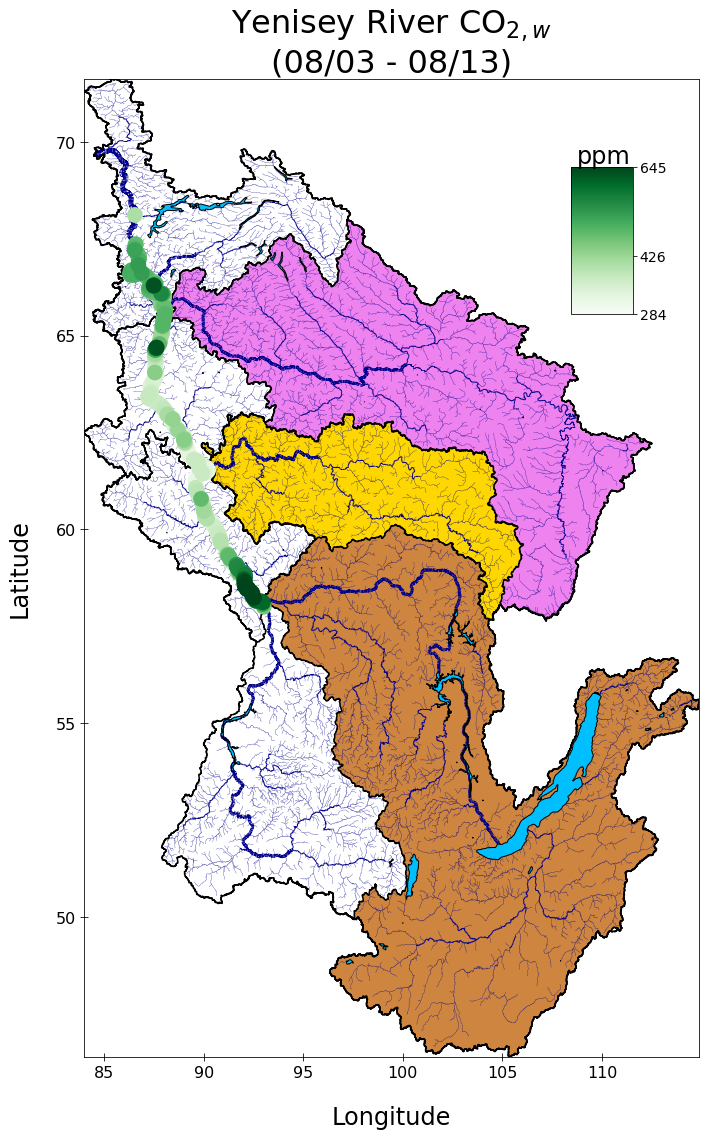

In [39]:
fig, ax = plt.subplots(figsize=(18, 18))

# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 5, 6
        elif flow_order == 3:
            lw, z = 3, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.333, 3
        elif flow_order == 6:
            lw, z = 0.25, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt.plot(ax=ax, color='violet', edgecolor='black', lw=1.5, zorder=0)
pt.plot(ax=ax, color='gold', edgecolor='black', lw=1.5, zorder=0)
angara.plot(ax=ax, color='peru', edgecolor='black', lw=1.5, zorder=0)
nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
gpd_lakes.plot(ax=ax, color='deepskyblue', edgecolor='black', lw=1, zorder=8)
ax.set_title("Yenisey River CO$_{2,w}$\n(08/03 - 08/13)", fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Scatter plot for 'Flux_co2_kg_hr'
#colors = ['steelblue' if value > 0 else 'red' for value in all_data['Flux_co2_kg_m2_hr']]
#ax.scatter(all_data['lon'], all_data['lat'], c=colors, ec='black', lw=0.75, s=250, zorder=9)
#ax.scatter(filtered_df_high['lon'], filtered_df_high['lat'], c='red', ec='black', lw=0.75, s=250, zorder=9)
#ax.scatter(filtered_df_low['lon'], filtered_df_low['lat'], c='steelblue', ec='black', lw=0.75, s=250, zorder=9)

m1 = ax.scatter(df2w_30T['lon_w'], df2w_30T['lat_w'], c=df2w_30T['co2_w'], cmap = 'Greens', 
                vmin = p2, vmax = p98, ec='none', lw=0.75, s=250, zorder=9)


# Colorbar 1
cb_ax1 = inset_axes(ax, width="10%", height="15%", loc='upper right', 
                    bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax.transAxes)
cb1 = plt.colorbar(m1, cax=cb_ax1)
cb1.set_label(r'ppm', fontsize=18, labelpad=15)
cb1.ax.tick_params(labelsize=14)
cb1.set_ticks([df2w_30T['co2_w'].quantile(0.02), 
               df2w_30T['co2_w'].mean(), 
               df2w_30T['co2_w'].quantile(0.98)])
cb1.set_ticklabels(['{:.0f}'.format(df2w_30T['co2_w'].quantile(0.02)), 
                    '{:.0f}'.format(df2w_30T['co2_w'].mean()), 
                    '{:.0f}'.format(df2w_30T['co2_w'].quantile(0.98))])
cb1.ax.yaxis.set_label_coords(0.100, 1.075)  # Adjust the x and y coordinates as needed
cb1.ax.set_ylabel(cb1.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')


# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zCO2_map_2.png', dpi = 600, bbox_inches='tight')

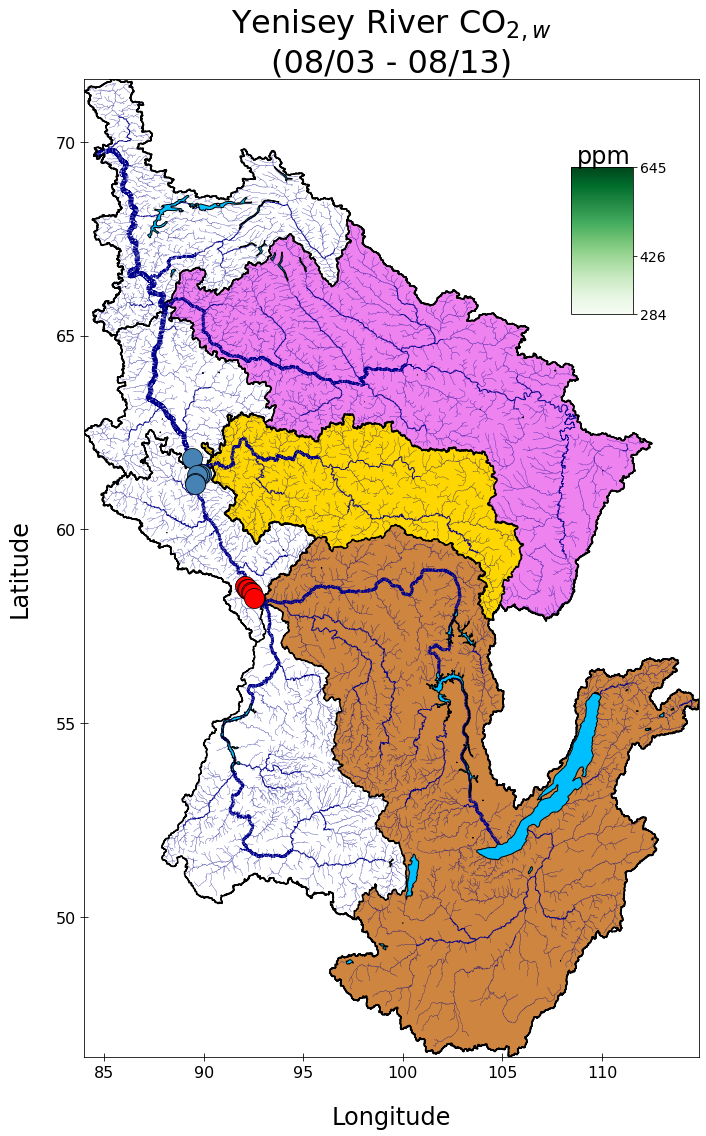

In [40]:
fig, ax = plt.subplots(figsize=(18, 18))

# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 5, 6
        elif flow_order == 3:
            lw, z = 3, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.333, 3
        elif flow_order == 6:
            lw, z = 0.25, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt.plot(ax=ax, color='violet', edgecolor='black', lw=1.5, zorder=0)
pt.plot(ax=ax, color='gold', edgecolor='black', lw=1.5, zorder=0)
angara.plot(ax=ax, color='peru', edgecolor='black', lw=1.5, zorder=0)
nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=0)
gpd_lakes.plot(ax=ax, color='deepskyblue', edgecolor='black', lw=1, zorder=8)
ax.set_title("Yenisey River CO$_{2,w}$\n(08/03 - 08/13)", fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

ax.scatter(filtered_df_high['lon_w'], filtered_df_high['lat_w'], c='red', ec='black', lw=0.75, s=400, zorder=9)
ax.scatter(filtered_df_low['lon_w'], filtered_df_low['lat_w'], c='steelblue', ec='black', lw=0.75, s=400, zorder=9)

# Colorbar 1
cb_ax1 = inset_axes(ax, width="10%", height="15%", loc='upper right', 
                    bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax.transAxes)
cb1 = plt.colorbar(m1, cax=cb_ax1)
cb1.set_label(r'ppm', fontsize=18, labelpad=15)
cb1.ax.tick_params(labelsize=14)
cb1.set_ticks([df2w_30T['co2_w'].quantile(0.02), 
               df2w_30T['co2_w'].mean(), 
               df2w_30T['co2_w'].quantile(0.98)])
cb1.set_ticklabels(['{:.0f}'.format(df2w_30T['co2_w'].quantile(0.02)), 
                    '{:.0f}'.format(df2w_30T['co2_w'].mean()), 
                    '{:.0f}'.format(df2w_30T['co2_w'].quantile(0.98))])
cb1.ax.yaxis.set_label_coords(0.100, 1.075)  # Adjust the x and y coordinates as needed
cb1.ax.set_ylabel(cb1.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')


# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('zCO2_map_2a.png', dpi = 600, bbox_inches='tight')

- https://arctic.noaa.gov/report-card/report-card-2020/terrestrial-snow-cover-3/
- https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00756